In [33]:
!pip install -U keras
!pip install -U tensorflow

Requirement already up-to-date: keras in c:\users\losh\appdata\local\programs\python\python38\lib\site-packages (2.7.0)

You should consider upgrading via the 'c:\users\losh\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.



Requirement already up-to-date: tensorflow in c:\users\losh\appdata\local\programs\python\python38\lib\site-packages (2.7.0)


You should consider upgrading via the 'c:\users\losh\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [34]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
# from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [35]:
import csv
import pandas as pd
join_BID_tor_v2 = pd.read_csv('D:\Ryerson\CIND820\Kaggle_yelp_dataset_CSV\join_BID_tor_v2.csv')

In [36]:
join_BID_tor_v2_samp = join_BID_tor_v2.sample(n = 20433 , random_state = 101)
train = join_BID_tor_v2_samp[0:14000]
test = join_BID_tor_v2_samp[14000:]

In [37]:
train.shape, test.shape

((14000, 23), (6433, 23))

,text,stars_y
14421,I think it must be a great deal for meat eater...,3
1561,"A beautiful, sunny day at The Beaches warrants...",4
4163,This is by far the best in its genre in the ci...,5
4623,I've been here about a handful of times and I'...,5
6184,Had dinner last night here and I have to say t...,2


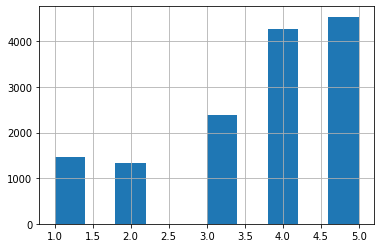

In [38]:
train = train[['text', 'stars_y']]
train['stars_y'].hist();train.head()

In [39]:
train = pd.get_dummies(train, columns = ['stars_y'])
train.head()

,text,stars_y_1,stars_y_2,stars_y_3,stars_y_4,stars_y_5
14421,I think it must be a great deal for meat eater...,0,0,1,0,0
1561,"A beautiful, sunny day at The Beaches warrants...",0,0,0,1,0
4163,This is by far the best in its genre in the ci...,0,0,0,0,1
4623,I've been here about a handful of times and I'...,0,0,0,0,1
6184,Had dinner last night here and I have to say t...,0,1,0,0,0


In [40]:
#test = pd.read_csv('/home/adam/R/Yelp/dataset/model_test.csv', usecols=['text', 'stars'])
test = test[['text', 'stars_y']]
test = pd.get_dummies(test, columns = ['stars_y'])
train.shape, test.shape

((14000, 6), (6433, 6))

In [41]:
# set frac = .33 to subsample in the initial trainings (to increase efficeny if needed)
# train_samp = train.sample(frac = .33, random_state = 42)
# test_samp = test.sample(frac = .33, random_state = 42)
# train_samp.shape, test_samp.shape   

In [42]:
# max_features is an upper bound on the number of words in the vocabulary
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

In [43]:
class NBFeatures(BaseEstimator):
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [44]:
# Create pipeline using sklearn pipeline:
    # I have created some tfidf features which are fed to my NB model 
    # for probability calculations. Then those are fed as input to my 
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [61]:
%%time
# The “CV score” is measuring the accuracy of each individual star rating
class_names = ['stars_y_1', 'stars_y_2', 'stars_y_3', 'stars_y_4', 'stars_y_5']
scores = []
preds = np.zeros((len(test), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train['text'].values, train_target)
    preds[:,i] = p.predict_proba(test['text'].values)[:,1]

CV score for class stars_y_1 is 0.9262857594551219
CV score for class stars_y_2 is 0.904285677592131
CV score for class stars_y_3 is 0.8329285952356656
CV score for class stars_y_4 is 0.7001431194079487
CV score for class stars_y_5 is 0.7929288805621716
Wall time: 20.8 s


In [62]:
%%time
# classification report
t = metrics.classification_report(np.argmax(test[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       684
           1       0.45      0.14      0.22       576
           2       0.51      0.35      0.41      1096
           3       0.47      0.55      0.51      1974
           4       0.64      0.76      0.69      2103

    accuracy                           0.56      6433
   macro avg       0.55      0.50      0.50      6433
weighted avg       0.55      0.56      0.55      6433

Wall time: 11.5 ms
